In [1]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import h5py
import glob
import dxchange
from tqdm import tqdm
import pandas as pd

In [2]:
autoreduce_path  = "/SNS/VENUS/IPTS-35945/shared/autoreduce/mcp/images/"
assert os.path.exists(autoreduce_path)
nexus_path = "/SNS/VENUS/IPTS-35945/nexus/"
assert os.path.exists(nexus_path)

In [3]:
title = "2.5c"

ob_folder = os.path.join(autoreduce_path, "Run_7818")
ob_nexus = os.path.join(nexus_path, "VENUS_7818.nxs.h5")
ob_frame_number = None

sample_folder = os.path.join(autoreduce_path, "Run_7822")
sample_nexus = os.path.join(nexus_path, "VENUS_7822.nxs.h5")
sample_frame_number = None

# test
assert os.path.exists(ob_folder)
assert os.path.exists(ob_nexus)
assert os.path.exists(sample_folder)
assert os.path.exists(sample_nexus)


In [4]:
def load_list_of_tif(list_of_tiff, dtype=None):
    if dtype is None:
        dtype = np.uint16

    # init array
    first_image = dxchange.read_tiff(list_of_tiff[0])
    size_3d = [len(list_of_tiff), np.shape(first_image)[0], np.shape(first_image)[1]]
    data_3d_array = np.empty(size_3d, dtype=dtype)

    # load stack of tiff
    for _index, _file in enumerate(tqdm(list_of_tiff)):
        _array = dxchange.read_tiff(_file)
        data_3d_array[_index] = _array
    return data_3d_array

# Goal

We will normalize the sample data by the OB using two methods and we will compare them

1. sample / ob using total shutter value given by NeXus
2. sample / ob using number of shutter values for each frame 
3. no shutter value correction

# Load data

In [5]:
# load the stack of images
print(f"Loading stack of ob images at {os.path.join(ob_folder, '*.tiff')}")
list_of_ob_images = glob.glob(os.path.join(ob_folder, "*.tif"))
list_of_ob_images.sort()
print("number of images: ", len(list_of_ob_images))

print(f"Loading stack of sample images at {os.path.join(sample_folder, '*.tiff')}")
list_of_sample_images = glob.glob(os.path.join(sample_folder, "*.tif"))
list_of_sample_images.sort()
print("number of images: ", len(list_of_sample_images))


Loading stack of ob images at /SNS/VENUS/IPTS-35945/shared/autoreduce/mcp/images/Run_7818/*.tiff
number of images:  2782
Loading stack of sample images at /SNS/VENUS/IPTS-35945/shared/autoreduce/mcp/images/Run_7822/*.tiff
number of images:  2782


In [6]:
ob_data = load_list_of_tif(list_of_ob_images)
sample_data = load_list_of_tif(list_of_sample_images)


100%|██████████| 2782/2782 [00:39<00:00, 71.18it/s]


Visualize the data

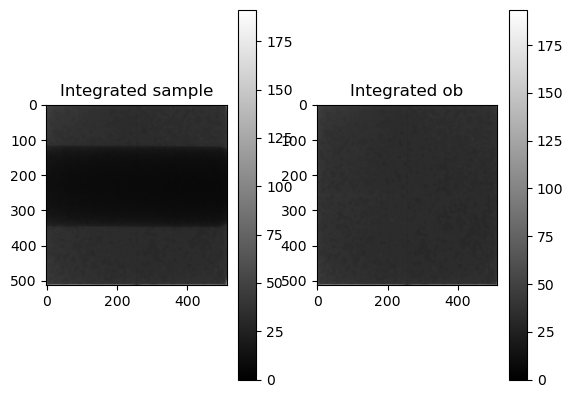

In [17]:
integrated_sample = np.mean(sample_data, axis=0)
integrated_ob = np.mean(ob_data, axis=0)

plt.figure()
plt.subplot(121)
plt.imshow(integrated_sample, cmap='gray')
plt.title("Integrated sample")
plt.colorbar()
plt.subplot(122)
plt.imshow(integrated_ob, cmap='gray')
plt.title("Integrated ob")
plt.colorbar()

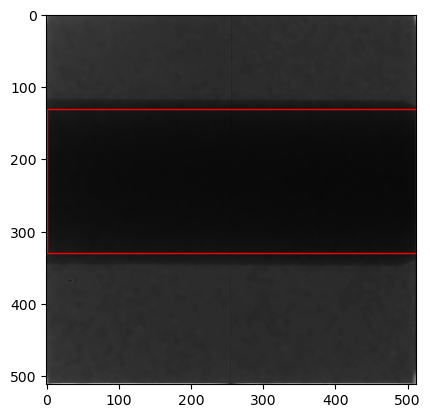

In [18]:
# select region to use

region = {'x0': 0, 'y0': 130, 'width': 512, 'height': 200}

plt.figure()
plt.imshow(integrated_sample, cmap='gray')
# display rectangle
rect = plt.Rectangle((region['x0'], region['y0']), region['width'], region['height'],
                     linewidth=1, edgecolor='r', facecolor='none')
plt.gca().add_patch(rect)

crop data

In [19]:
sample_data_cropped = [_data[region['y0']:region['y0'] + region['height'], region['x0']:region['x0'] + region['width']] for _data in sample_data]
ob_data_cropped = [_data[region['y0']:region['y0'] + region['height'], region['x0']:region['x0'] + region['width']] for _data in ob_data]

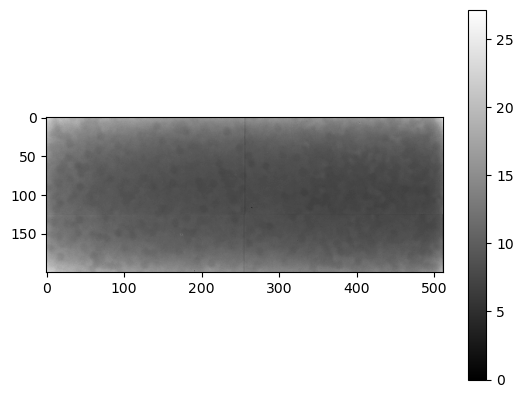

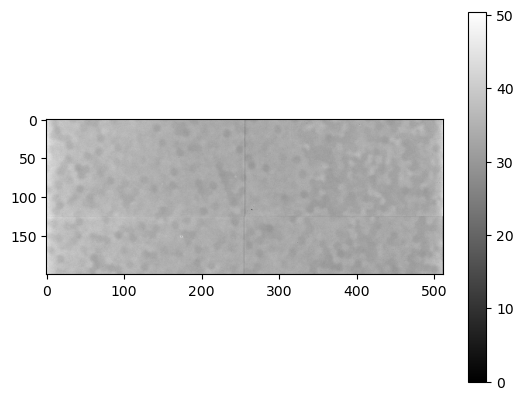

In [20]:
integrated_sample = np.mean(sample_data_cropped, axis=0)
plt.figure()
plt.imshow(integrated_sample, cmap='gray')
plt.colorbar()

integrated_ob = np.mean(ob_data_cropped, axis=0)
plt.figure()
plt.imshow(integrated_ob, cmap='gray')
plt.colorbar()

# 1. Sample / ob using total shutter value given by NeXus

In [21]:
with h5py.File(ob_nexus, 'r') as hdf5_data:
    ob_frame_number = hdf5_data['entry']['DASlogs']['BL10:Det:PIXELMAN:ACQ:NUM']['value'][:][-1]

with h5py.File(sample_nexus, 'r') as hdf5_data:
    sample_frame_number = hdf5_data['entry']['DASlogs']['BL10:Det:PIXELMAN:ACQ:NUM']['value'][:][-1]

print("ob frame number: ", ob_frame_number)
print("sample frame number: ", sample_frame_number)

ob frame number:  1811
sample frame number:  1823


perform simple normalization image per image and applying the coefficient

In [22]:
coefficient = ob_frame_number / sample_frame_number
print("coefficient: ", coefficient)

coefficient:  0.9934174437739989


In [23]:
print(f"{len(ob_data_cropped)} ob images")
print(f"{len(sample_data_cropped)} sample images")

2782 ob images
2782 sample images


In [24]:
normalized_data_method1 = np.empty_like(sample_data_cropped, dtype=np.float32)
                                             
index = 0                                                                        
for _sample, _ob in zip(sample_data_cropped, ob_data_cropped):
    _sample = _sample.astype(np.float32)
    _ob = _ob.astype(np.float32)

    # using numpy, replace 0 values by NaN
    _sample[_sample == 0] = np.nan
    _ob[_ob == 0] = np.nan 

    # calculate the ratio
    _ratio = np.divide(_sample, _ob) * coefficient

    normalized_data_method1[index] = _ratio
    index += 1

In [25]:
# plotting the full profile
profile_1 = np.nanmean(normalized_data_method1, axis=1)
profile1 = np.nanmean(profile_1, axis=1)
print(np.shape(profile1))

(2782,)


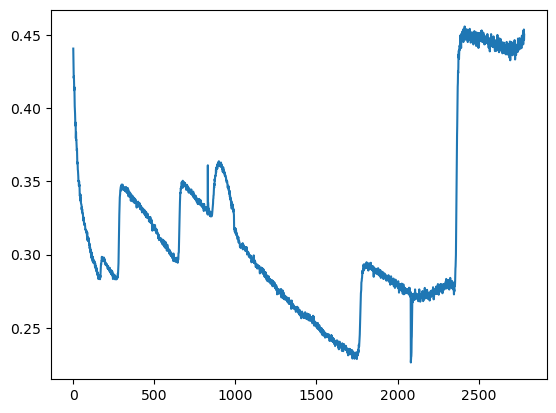

In [26]:
plt.figure(0)
plt.plot(profile1)

# 2. sample / ob using number of shutter values for each frame 

retrieve shutter values from shutter file

In [27]:
_list_file = glob.glob(os.path.join(ob_folder, "*_ShutterCount.txt"))
ob_shutter_count_file = _list_file[0]
print(ob_shutter_count_file)

_list_file = glob.glob(os.path.join(sample_folder, "*_ShutterCount.txt"))
sample_shutter_count_file = _list_file[0]
print(sample_shutter_count_file)

/SNS/VENUS/IPTS-35945/shared/autoreduce/mcp/images/Run_7818/Run_7818_20250415_April15_2025_OB_2_5C_1_9_Ang_min_0002_2381009_ShutterCount.txt
/SNS/VENUS/IPTS-35945/shared/autoreduce/mcp/images/Run_7822/Run_7822_20250416_April15_2025_Ni_2_5C_1_9_Ang_min_0002_2385014_ShutterCount.txt


In [28]:
with open(ob_shutter_count_file, 'r') as f:
    lines = f.readlines()
    list_shutter_values_ob = []
    for _line in lines[:]:
        _, _value = _line.strip().split("\t")
        if _value == "0":
            break
        list_shutter_values_ob.append(float(_value))

list_shutter_values_ob = [float(_value) for _value in list_shutter_values_ob]

with open(sample_shutter_count_file, 'r') as f:
    lines = f.readlines()
    list_shutter_values_sample = []
    for _line in lines[:]:
        _, _value = _line.strip().split("\t")
        if _value == "0":
            break
        list_shutter_values_sample.append(float(_value))

list_shutter_values_sample = [float(_value) for _value in list_shutter_values_sample]

In [29]:
print(f"{list_shutter_values_sample = }")
print(f"{list_shutter_values_ob = }")

list_shutter_values_sample = [109509.0, 109487.0, 109140.0, 109512.0, 109552.0]
list_shutter_values_ob = [109294.0, 109051.0, 107689.0, 108683.0, 108883.0]


let's figure out the which image belongs to each frame

In [30]:
# _list_file = glob.glob(os.path.join(ob_folder, "*_Spectra.txt"))
# ob_spectra_file = _list_file[0]
# print(f"ob spectra file: {os.path.basename(ob_spectra_file)}")

_list_file = glob.glob(os.path.join(sample_folder, "*_Spectra.txt"))
sample_spectra_file = _list_file[0]
print(f"sample spectra file: {os.path.basename(sample_spectra_file)}")


sample spectra file: Run_7822_20250416_April15_2025_Ni_2_5C_1_9_Ang_min_0002_2385014_Spectra.txt


In [31]:
# pd_ob = pd.read_csv(ob_spectra_file, sep=",", header=0)
pd_sample = pd.read_csv(sample_spectra_file, sep=",", header=0)

In [32]:
# ob_shutter_time = pd_ob['shutter_time'].values
sample_shutter_time = pd_sample['shutter_time'].values

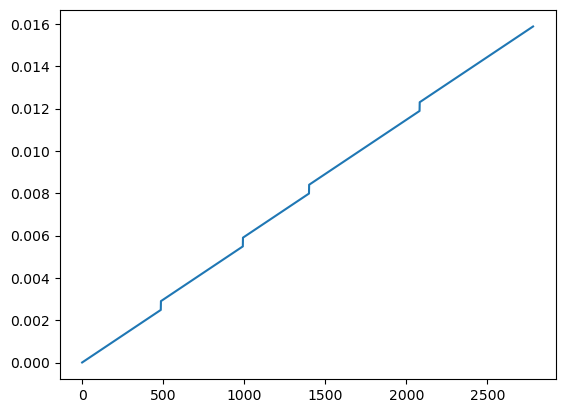

In [33]:
plt.figure()
plt.plot(sample_shutter_time, label="sample")

indexes of jump: [ 485  991 1399 2081]


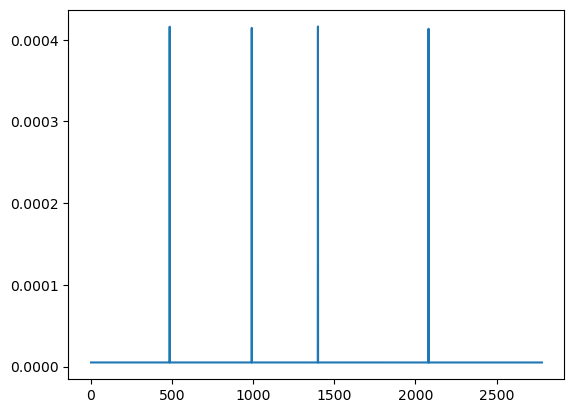

In [34]:
# find the jump in the shutter time
shutter_time_diff = np.diff(sample_shutter_time)
plt.figure()
plt.plot(shutter_time_diff, label="sample")

# find the index of the jump
list_index_jump = np.where(shutter_time_diff > 0.0001)[0]
print(f"indexes of jump: {list_index_jump}")

In [35]:
list_shutter_value_for_each_image = np.zeros_like(list_of_sample_images, dtype=np.float32)
list_ob_shutter_value_for_each_image = np.zeros_like(list_of_ob_images, dtype=np.float32)


In [36]:
list_index_jump[0]

485

In [37]:
list_shutter_value_for_each_image[0: list_index_jump[0]].fill(list_shutter_values_sample[0])
list_ob_shutter_value_for_each_image[0: list_index_jump[0]].fill(list_shutter_values_ob[0])
for _index in range(1, len(list_index_jump)):
    _start = list_index_jump[_index - 1]
    _end = list_index_jump[_index]
    list_shutter_value_for_each_image[_start: _end].fill(list_shutter_values_sample[_index])
    list_ob_shutter_value_for_each_image[_start: _end].fill(list_shutter_values_ob[_index])

list_shutter_value_for_each_image[list_index_jump[-1]:] = list_shutter_values_sample[-1]
list_ob_shutter_value_for_each_image[list_index_jump[-1]:] = list_shutter_values_ob[-1]


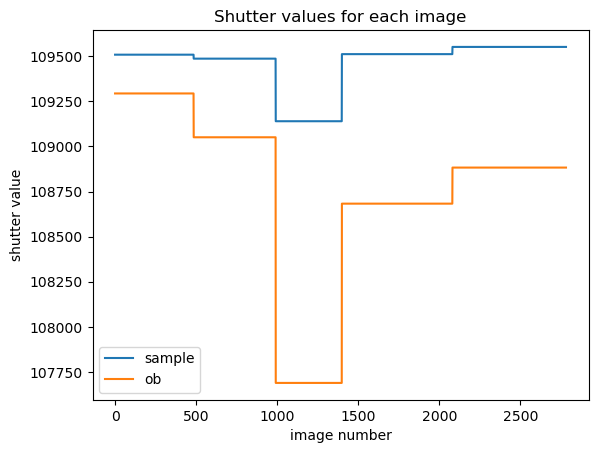

In [38]:
plt.figure()
plt.title("Shutter values for each image")
plt.xlabel("image number")
plt.ylabel("shutter value")
plt.plot(list_shutter_value_for_each_image, label="sample")
plt.plot(list_ob_shutter_value_for_each_image, label="ob")
plt.legend()

normalization

In [39]:
normalized_data_method2 = np.empty_like(sample_data_cropped, dtype=np.float32)
                                             
index = 0                                                                        
for _sample, _ob in zip(sample_data_cropped, ob_data_cropped):
    _sample = _sample.astype(np.float32)
    _ob = _ob.astype(np.float32)

    # using numpy, replace 0 values by NaN
    _sample[_sample == 0] = np.nan
    _ob[_ob == 0] = np.nan 

    # coefficient
    _sample_shutter_value = float(list_shutter_value_for_each_image[index])
    _ob_shutter_value = float(list_ob_shutter_value_for_each_image[index])
       
    _coefficient = _ob_shutter_value / _sample_shutter_value



    # calculate the ratio
    _ratio = np.divide(_sample, _ob) * _coefficient

    normalized_data_method2[index] = _ratio
    index += 1

In [40]:
# plotting the full profile
profile2_1 = np.nanmean(normalized_data_method2, axis=1)
profile2 = np.nanmean(profile2_1, axis=1)
print(np.shape(profile2))

(2782,)


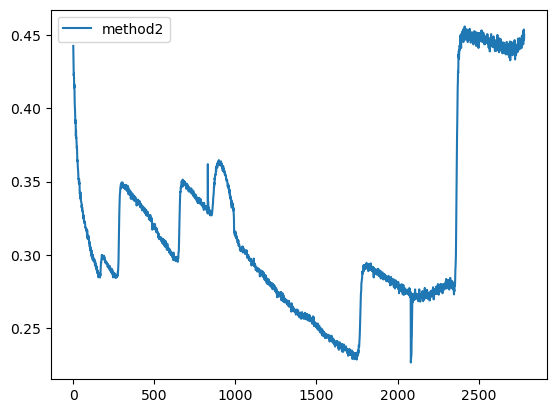

In [41]:
plt.figure(0)
plt.plot(profile2, label='method2')
plt.legend()

# 3. Without shutter value correction

In [42]:
normalized_data_method3 = np.empty_like(sample_data_cropped, dtype=np.float32)
                                             
index = 0                                                                        
for _sample, _ob in zip(sample_data_cropped, ob_data_cropped):
    _sample = _sample.astype(np.float32)
    _ob = _ob.astype(np.float32)

    # using numpy, replace 0 values by NaN
    _sample[_sample == 0] = np.nan
    _ob[_ob == 0] = np.nan 

    # calculate the ratio
    _ratio = np.divide(_sample, _ob)

    normalized_data_method3[index] = _ratio
    index += 1

In [43]:
# plotting the full profile
profile3_1 = np.nanmean(normalized_data_method3, axis=1)
profile3 = np.nanmean(profile3_1, axis=1)
print(np.shape(profile3))

(2782,)


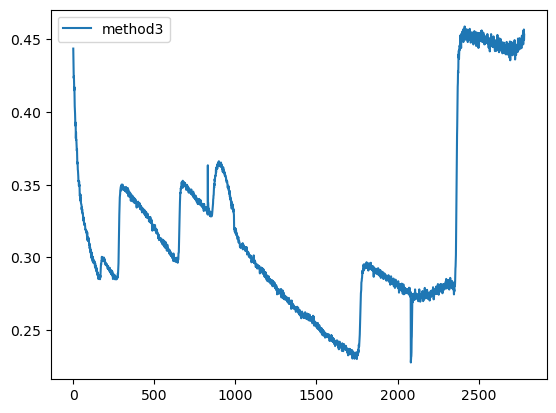

In [44]:
plt.figure(0)
plt.plot(profile3, label='method3')
plt.legend()

# Recap

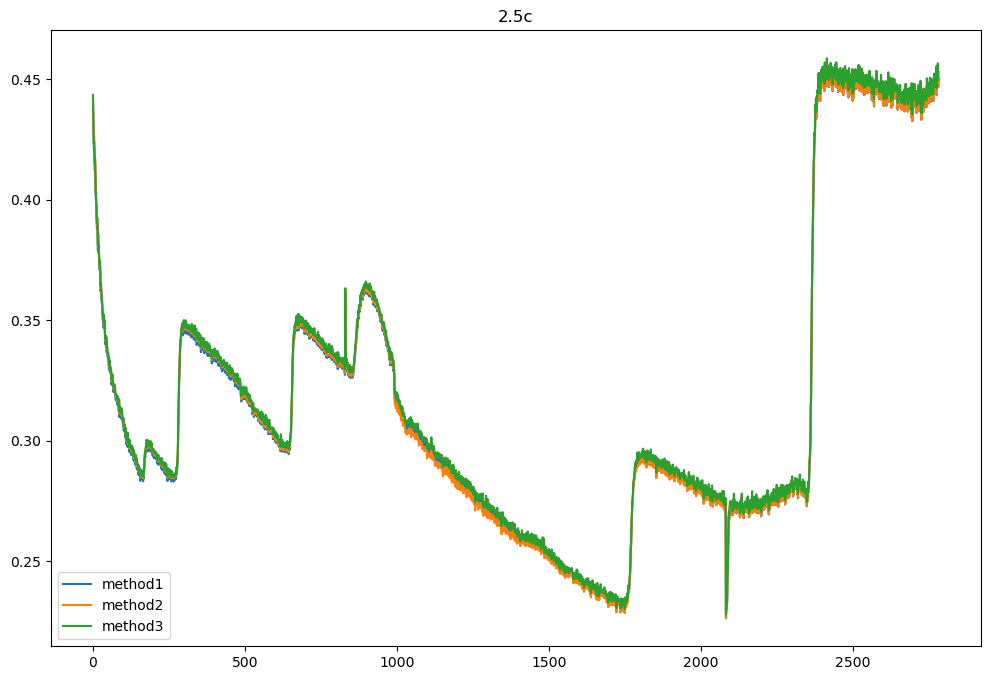

In [45]:
plt.figure(figsize=(12, 8))
plt.title(f"{title}")
plt.plot(profile1, label='method1')
plt.plot(profile2, label='method2')
plt.plot(profile3, label='method3')
plt.legend()


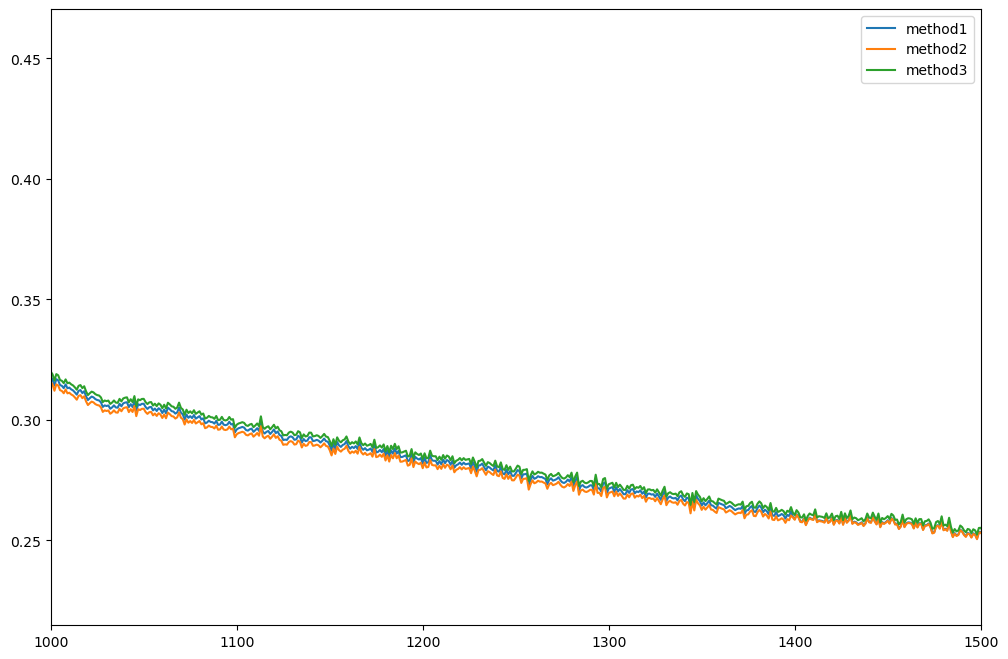

In [36]:
plt.figure(figsize=(12, 8))
plt.plot(profile1, label='method1')
plt.plot(profile2, label='method2')
plt.plot(profile3, label='method3')
plt.xlim(1000, 1500)
plt.legend()